<a href="https://colab.research.google.com/github/chandan2294/Time-Series-with-Deep-Learning-/blob/master/6.%20Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


Let's write the code to set up the data and create a dataset.

In [0]:
def plot_series(time, series, format = '-', start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope = 0):
  return time * slope

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2* np.pi),
                  1/np.exp(3 * season_time))
  
def seasonality(time, period, amplitude =  1, phase = 0):
  season_time = ((time + phase)%period)/period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time = np.arange(4*365+1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

#Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#Update with noise
series += noise(time, noise_level, seed = 42)

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

The inputs of RNN are three dimensional. So for example, if we have a window size of 30 timestamps and we're batching them in sizes of four, the shape will be 4 times 30 times 1, (1 for univariate). At each timestamp, the memory cell input will be a four by one matrix. The cell will also take the input of the state matrix from the previous step. The first step will be zero. For subsequent ones, it'll be the output from the memory cell (H0, H1, H2,...). Other than the state vector, the cell will output a Y value ($\hat{Y_1}, \hat{Y_2}, ...$). 

If the memory cell is comprised of three neurons, then the output matrix ($\hat{Y}$ will be comprised of (4,3) because the batch size coming in was 4 and the number of neurons is 3. So the full output is (4, 30, 3) (30 being the timesize).

In a simple RNN, the state output H is just a copy of the output matrix $\hat{Y}$. So for example, $H_0$ is a copy of $\hat{Y_0}$, $H_1$ is a copy of $\hat{Y_1}$, and so on. So at each timestamp, the memory cell gets both the current input and also the previous output.

In sequence to vector, you ignore all the outputs except the last timestamp output. When using Keras in TensorFlow, this is the default behavior. So if you want the recurrent layer to output a sequence, you have to specify returns sequences equals True when creating the layer. You'll need to do this when you stack one RNN layer on top of another.

In [0]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                               input_shape = [None]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40), #40 is the timestamps
        tf.keras.layers.Dense(1), #1 because we're using a univariate time series
        tf.keras.layers.Lambda(lambda x: x * 100)
])

So consider this RNN, these has two recovered layers, and the first has return_sequences=True set up. It will output a sequence which is fed to the next layer. The next layer does not have return_sequence that's set to True, so it will only output to the final step.

Notice the input_shape, it's set to None and 1. TensorFlow assumes that the first dimension is the batch size, and that it can have any size at all, so you don't need to define it.


Lambda layer perform arbitrary operations to effectively expand the functionality of TensorFlow's keras, and we can do this within the model definition itself. So the first Lambda layer will be used to help us with our dimensionality. 
> tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1), input_shape = [None])

If you recall when we wrote the window dataset helper function, it returned two-dimensional batches of windows on the data, with the first being the batch size and the second the number of timestamps. But an RNN expects three-dimensions; batch size, the number of timestamps, and the series dimensionality. With the Lambda layer, we can fix this without rewriting our window dataset helper function. Using the Lambda, we just expand the array by one dimension. By setting input shape to none, we're saying that the model can take sequences of any length.

Similarly, if we scale up the outputs by 100, we can help training. The default activation function in the RNN layers is tan H which is the hyperbolic tangent activation. This outputs values between negative one and one. Since the time series values are in that order usually in the 10s like 40s, 50s, 60s, and 70s, then scaling up the outputs to the same ballpark can help us with learning. We can do that in a Lambda layer too, we just simply multiply that by a 100.

> tf.keras.layers.Lambda(lambda x: x*100.0)

In [17]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(train_set, epochs = 100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 15ms/step - loss: 120.6113 - mae: 121.0560 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 120.1957 - mae: 120.5839 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 119.2721 - mae: 119.8328 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 118.2666 - mae: 118.9010 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 117.1605 - mae: 117.8336 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 116.2416 - mae: 116.6293 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 114.6044 - mae: 115.3002 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 113.2970 - mae: 113.8327 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 111.8981 - mae: 

To tune the learning rate, we'll set up a callback, which you can see here. 

> lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

Every epoch this just changes the learning rate a little so that it steps all the way from $1 \times 10^-8$ to $1\times 10^-6$. You can see that setup here while training.

I've also introduced a new loss function to use called Huber. The Huber function is a loss function that's less sensitive to outliers and as this data can get a little bit noisy, it's worth giving it a shot.


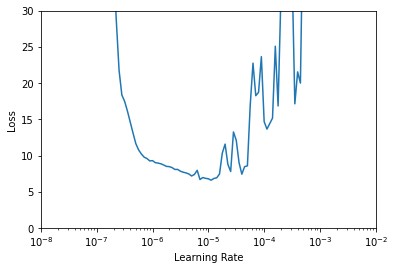

In [21]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

The loss is minimum around 1e-5


In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                               input_shape = [None]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100)           
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(dataset, epochs = 400)

Epoch 1/400
8/8 [==============================] - 0s 11ms/step - loss: 100.9211 - mae: 102.8677
Epoch 2/400
8/8 [==============================] - 0s 11ms/step - loss: 27.3708 - mae: 28.4984
Epoch 3/400
8/8 [==============================] - 0s 11ms/step - loss: 16.8882 - mae: 17.4342
Epoch 4/400
8/8 [==============================] - 0s 12ms/step - loss: 14.3139 - mae: 14.9153
Epoch 5/400
8/8 [==============================] - 0s 13ms/step - loss: 11.1355 - mae: 11.6457
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 9.2968 - mae: 9.8279
Epoch 7/400
8/8 [==============================] - 0s 10ms/step - loss: 8.0972 - mae: 8.6231
Epoch 8/400
8/8 [==============================] - 0s 14ms/step - loss: 6.5357 - mae: 6.9713
Epoch 9/400
8/8 [==============================] - 0s 11ms/step - loss: 5.9906 - mae: 6.5374
Epoch 10/400
8/8 [==============================] - 0s 10ms/step - loss: 5.9140 - mae: 6.3560
Epoch 11/400
8/8 [==============================] - 0s 10

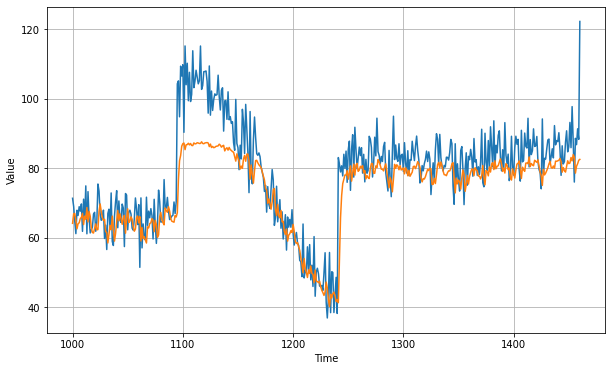

In [24]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.5774565

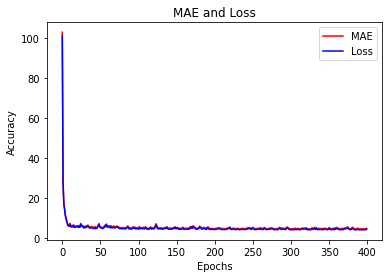

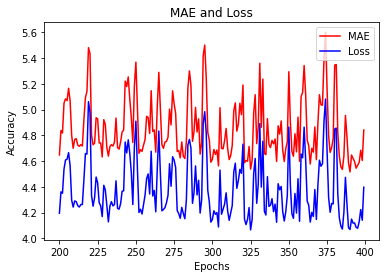

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))  #Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MAE and Loss")
plt.legend(['MAE', 'Loss'])
plt.show()